In [1]:
using Revise

In [2]:
using Distributed
procs_to_use = 1

if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end

@everywhere using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase,
    Distributions,
    StructArrays,
    StaticArrays,
    StructArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples

@everywhere @consts begin
    λ = 626e-9
    Γ = 2π* 6.4e6
    m = @with_unit 57 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    kB = 1.380649e-23
end
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]


In [3]:
@everywhere sim_params = MutableNamedTuple(
    
    pol_imbalance = 0.0,
    s_imbalance = (0., 0., 0.),
    retro_loss = 0.,
    off_center = (0, 0, 0, 0, 0, 0) .* 1e-3,
    pointing_error = (0, 0, 0, 0, 0, 0),
    
    # pol_imbalance = 0.03,
    # s_imbalance = (0., 0., 0.),
    # retro_loss = 0.2,
    # off_center = (1, 1, 1, 1, 1, 1) .* 1e-3,
    # pointing_error = (0, 0, 0, 0, 0, 0),

    B_gradient = +72,
    B_ramp_time = 4e-3,
    B_offset = (0., 0., 0.),
    
    s_ramp_time = 4e-3,
    # s_ramp_to = 0.7/0.9,
    s_ramp_to = 1.0,

    s1 = s1,
    s2 = s2,
    s3 = s3,
    s4 = 0.0,
    Δ1 = detuning,
    Δ2 = detuning + δ1,
    Δ3 = detuning + δ2,
    Δ4 = 0.0,
    pol1_x = [1,0,0],
    pol2_x = [0,0,1],
    pol3_x = [1,0,0],
    pol4_x = [0,0,1]

)
;

LoadError: TaskFailedException

[91m    nested task error: [39mUndefVarError: `detuning` not defined
    Stacktrace:
     [1] top-level scope
    [90m   @[39m [90m[4mnone:1[24m[39m
     [2] [0m[1meval[22m
    [90m   @[39m [90m.\[39m[90m[4mboot.jl:370[24m[39m[90m [inlined][39m
     [3] [0m[1m(::Distributed.var"#172#174"{Module, Expr})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [35mDistributed[39m [90m.\[39m[90m[4mtask.jl:514[24m[39m

### Calculate transition dipole moments

In [4]:
@everywhere begin
    include("define_CaOH_states.jl")
    X_states, A_states = define_CaOH_states()
    states = [X_states; A_states[1:4]]
    d = tdms_between_states(states, states)
end
;

### Define lasers

In [336]:
@everywhere begin
    include("define_lasers_switching.jl")
    # include("define_lasers_extra.jl")
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )
end
;

### Define Zeeman Hamiltonian

In [337]:
@everywhere include("define_Zeeman_Hamiltonian.jl")
;

### Run simulation

In [338]:
@everywhere function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx
    Zeeman_Hy = p.extra_data.Zeeman_Hy
    
    τ_bfield = p.sim_params.B_ramp_time / (1/Γ)
    scalar = t/τ_bfield
    scalar = min(scalar, 1.0)
    
    gradient_x = -scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_y = +scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_z = -scalar * p.sim_params.B_gradient * 1e2 / k
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end
    
    ∇H = SVector{3, Float64}(0,0,0)
    
    return ∇H
end
;

In [339]:
@everywhere extra_data = MutableNamedTuple(
    Zeeman_Hx = Zeeman_x_mat,
    Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat
)
;

In [340]:
@everywhere begin
    t_start = 0.0
    t_end   = 5e-3
    t_span  = (t_start, t_end) ./ (1/Γ)

    n_states = length(states)
    n_excited = 4

    particle = Particle()
    particle.r = (0, 0, 0.5e-3) ./ (1/k)
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
end

using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p)

cb = ContinuousCallback(condition, SE_collapse_pol_always!, nothing, save_positions=(false,false))
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=5e-4, callback=cb, saveat=1000, maxiters=80000000, progress=true, progress_steps=200000)
;

ODE   0%|█                                              |  ETA: N/A
ODE  16%|████████                                       |  ETA: 0:00:12
ODE  32%|████████████████                               |  ETA: 0:00:10
ODE  48%|███████████████████████                        |  ETA: 0:00:08
ODE  64%|███████████████████████████████                |  ETA: 0:00:05
ODE  81%|██████████████████████████████████████         |  ETA: 0:00:03
ODE  97%|██████████████████████████████████████████████ |  ETA: 0:00:01


 18.715504 seconds (4.89 M allocations: 321.880 MiB, 0.70% gc time, 19.49% compilation time)


ODE 100%|███████████████████████████████████████████████| Time: 0:00:15


In [341]:
plot_us = sol.u
plot_ts = sol.t
x_trajectories = [real(u[n_states + n_excited + 1]) for u in plot_us]./k*1e3
y_trajectories = [real(u[n_states + n_excited + 2]) for u in plot_us]./k*1e3
z_trajectories = [real(u[n_states + n_excited + 3]) for u in plot_us]./k*1e3
;

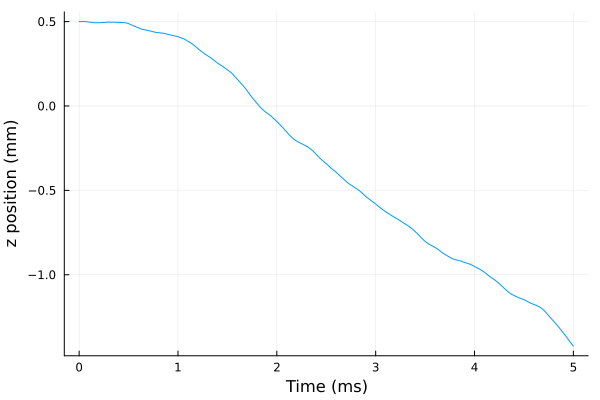

In [346]:
plot(sol.t .* (1e3/Γ), z_trajectories, 
    legend=nothing,
    xlabel="Time (ms)",
    ylabel="z position (mm)"
)

In [343]:
prob.p.n_scatters / t_end

1.2346e6

### Run simulation for multiple particles in parallel

In [260]:
@everywhere function prob_func(prob, i, repeat)
    
     lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )
    
    # Define initial conditions for the molecule
    cloud_size = @with_unit 0.1 "mm"
    particle = Particle()
    particle.r = (rand(Normal(0., cloud_size)), rand(Normal(0.1e-3, cloud_size)), rand(Normal(0.1e-3, cloud_size))) ./ (1/k)
    
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    
    p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    
    callback = ContinuousCallback(condition, SE_collapse_pol_always!, nothing, save_positions=(false,false))
    
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p, callback=callback, reltol=5e-4, saveat=4000, maxiters=80000000)
    
    return prob
end
;

In [261]:
ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
;

In [262]:
n_molecules = 20
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleDistributed(); trajectories=n_molecules)
;

119.067628 seconds (602.13 k allocations: 21.896 MiB, 0.03% gc time)


In [266]:
x_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
y_trajectories = Array{Vector{Float64}}(fill([],n_molecules)) 
z_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
x_velocities = Array{Vector{Float64}}(fill([],n_molecules))
y_velocities = Array{Vector{Float64}}(fill([],n_molecules))
z_velocities = Array{Vector{Float64}}(fill([],n_molecules))
photons_scattered = zeros(n_molecules)

times = Array{Vector{Float64}}(fill([],n_molecules))

for i ∈ 1:n_molecules
    sol_u = ensemble_sol[i].u
    sol_t = ensemble_sol[i].t
    
    x_trajectories[i] = [x_trajectories[i]; [real(u[n_states + n_excited + 1]) for u in sol_u] ./ k*1e3]
    y_trajectories[i] = [y_trajectories[i]; [real(u[n_states + n_excited + 2]) for u in sol_u] ./ k*1e3]
    z_trajectories[i] = [z_trajectories[i]; [real(u[n_states + n_excited + 3]) for u in sol_u] ./ k*1e3]
    
    x_velocities[i] = [x_velocities[i]; [real(u[n_states + n_excited + 4]) for u in sol_u] ./ (k/Γ)]
    y_velocities[i] = [y_velocities[i]; [real(u[n_states + n_excited + 5]) for u in sol_u] ./ (k/Γ)]
    z_velocities[i] = [z_velocities[i]; [real(u[n_states + n_excited + 6]) for u in sol_u] ./ (k/Γ)]
    
    photons_scattered[i] = ensemble_sol[i].prob.p.n_scatters
    
    times[i] = sol_t .* (1/Γ)
end

trajectories = [
    [[x[1],x[2],x[3]] for x ∈ zip(x_trajectories[i], y_trajectories[i], z_trajectories[i])] 
    for i ∈ 1:n_molecules
    ]
;

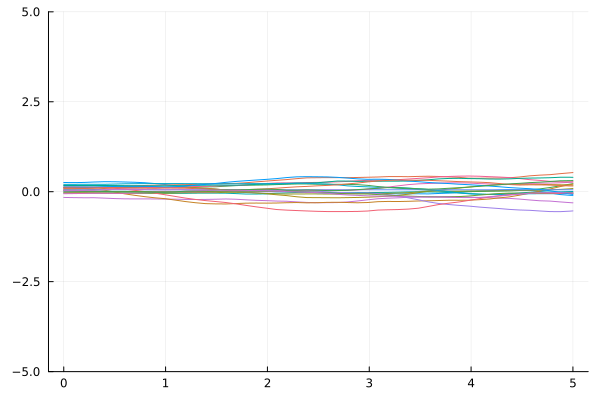

In [270]:
lim = 5.0
plot()
for i ∈ 1:n_molecules
    plot!(times[i] .* 1e3, z_trajectories[i], legend=nothing, ylim=(-lim, lim))
end
plot!()

In [265]:
function survived(i, t_end, times)
    return t_end ≈ times[i][end]
end

survived_molecules = [i for i ∈ 1:n_molecules if survived(i, t_end, times)]

survived_times = times[survived_molecules]

survived_x_trajectories = x_trajectories[survived_molecules]
survived_y_trajectories = y_trajectories[survived_molecules]
survived_z_trajectories = z_trajectories[survived_molecules]

survived_x_velocities = x_velocities[survived_molecules]
survived_y_velocities = y_velocities[survived_molecules]
survived_z_velocities = z_velocities[survived_molecules]
;

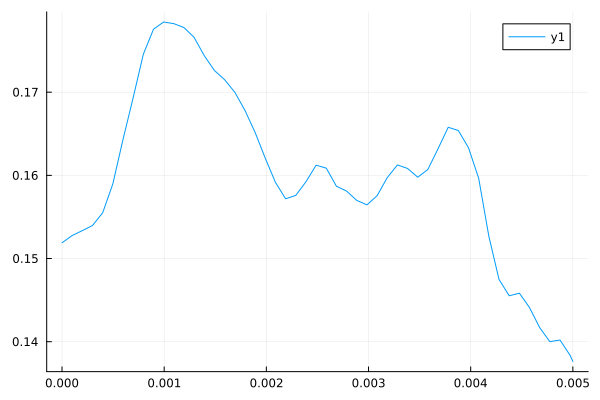

In [254]:
x_centers = mean(survived_z_trajectories)
plot(survived_times[1], x_centers)

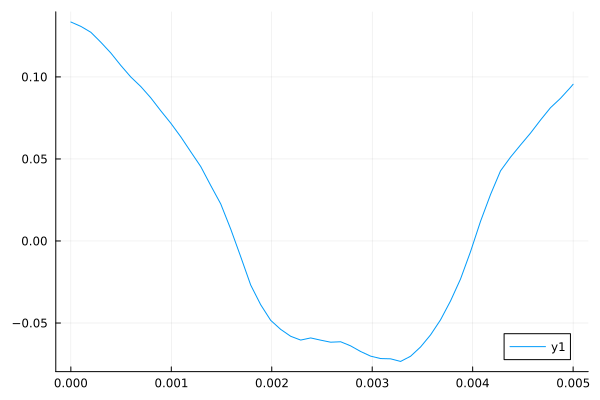

In [147]:
y_centers = mean(survived_y_trajectories)
plot(survived_times[1], y_centers)

In [148]:
function cloud_size(time, times, x_trajectories, y_trajectories, z_trajectories)
    xs = []
    ys = []
    zs = []
    for i ∈ eachindex(times)
        time_idx = searchsortedfirst(times[i], time)
        if length(times[i]) > time_idx
            push!(xs, x_trajectories[i][time_idx])
            push!(ys, y_trajectories[i][time_idx])
            push!(zs, z_trajectories[i][time_idx])
        end
    end
    return (std(xs) * std(ys) * std(zs))^(1/3)
end

using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2)) 
end

function cloud_size_fitted(xs)

    hist_data = fit(Histogram, xs, -0.2:0.02:0.2)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    histogram(hist_data)
    
    v_fit = curve_fit(Gaussian, v, fv, [0.05, 0., 5])
    σ, x0, A = v_fit.param
    
    # display(v_fit.param)
    # plot(v, Gaussian(v, v_fit.param))
    histogram!(xs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    
    return σ
end
;

3-element Vector{Float64}:
 0.05750286871477304
 0.002770267811771175
 6.623083410014048

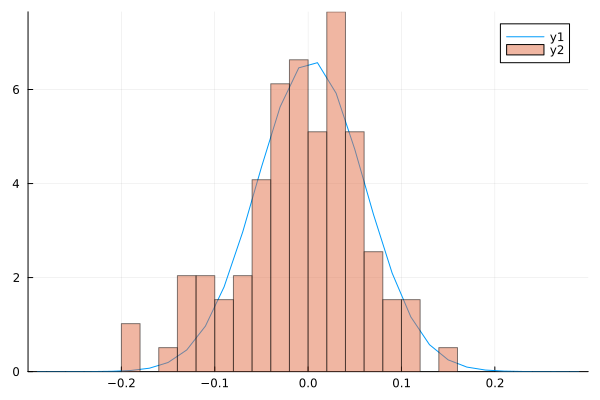

In [1392]:
xs = [x_trajectories[i][end] for i ∈ (1:n_molecules)[survived_molecules]]
ys = [y_trajectories[i][end] for i ∈ (1:n_molecules)[survived_molecules]]
zs = [z_trajectories[i][end] for i ∈ (1:n_molecules)[survived_molecules]]

hist_data = fit(Histogram, ys, -0.3:0.02:0.3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.05, 0., 5])
σ, x0, A = v_fit.param

display(v_fit.param)
plot(v, Gaussian(v, v_fit.param))
histogram!(ys, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)

In [1393]:
cloud_size_fitted(zs)

0.05143574129139601

In [1394]:
cloud_sizes = [cloud_size(t, 
        times[survived_molecules], 
        x_trajectories[survived_molecules], 
        y_trajectories[survived_molecules], 
        z_trajectories[survived_molecules]) 
    for t ∈ 0:0.1e-3:4.9e-3]
;

In [1395]:
cloud_sizes_x_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_x_trajectories]) for i ∈ eachindex(x_trajectories[survived_molecules][1])]
cloud_sizes_y_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_y_trajectories]) for i ∈ eachindex(y_trajectories[survived_molecules][1])]
cloud_sizes_z_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_z_trajectories]) for i ∈ eachindex(z_trajectories[survived_molecules][1])]
cloud_sizes_fitted = (abs.(cloud_sizes_x_fitted) .* abs.(cloud_sizes_y_fitted) .* abs.(cloud_sizes_z_fitted)).^(1/3)
;

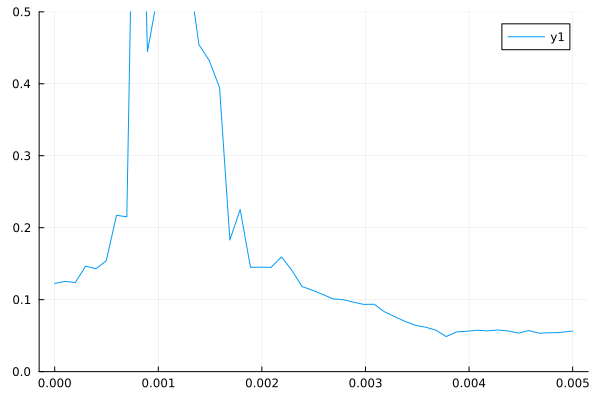

In [1396]:
plot(survived_times[1], cloud_sizes_fitted, ylim=(0,0.5))

In [1397]:
cloud_sizes_fitted

52-element Vector{Float64}:
 0.12253570964626852
 0.12543472313110257
 0.12379789810204013
 0.14652293525090906
 0.14292508338051144
 0.1539136641781495
 0.2171661747180786
 0.2151774572178509
 1.0174323619713035
 0.4446800648556073
 0.5232223839441977
 0.5796133361579062
 0.9816210514900184
 ⋮
 0.05608954459716364
 0.057504046537501054
 0.05660519421751611
 0.05780816281059146
 0.0565869725253334
 0.05349492540094929
 0.05700184444808903
 0.05342413197537214
 0.05393986420894761
 0.05431709348860869
 0.05599529560838939
 0.05622794439753235

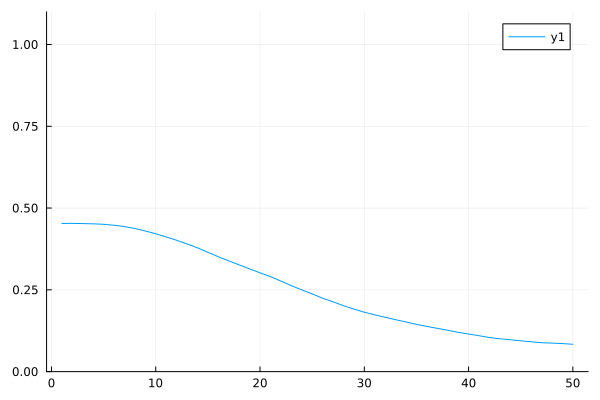

In [1369]:
plot(cloud_sizes, ylim=(0,1.1))

In [1370]:
cloud_sizes

50-element Vector{Float64}:
 0.4530878892217868
 0.45315430148897307
 0.4526114513866853
 0.45177174653864044
 0.45041729456820706
 0.44746402238595456
 0.4435125291915847
 0.43748410594065895
 0.429804556830384
 0.421436476446675
 0.4117118062151181
 0.4015672430498925
 0.39035767249218395
 ⋮
 0.12005567751917383
 0.1150026953274291
 0.10978225821556856
 0.10428928588908638
 0.10042411852105473
 0.09737615776717752
 0.09420022602626456
 0.09130130379951451
 0.0883290283394855
 0.08723201018736634
 0.08565000981697758
 0.0836168127027134

In [1371]:
mean(ensemble_sol[i].prob.p.n_scatters / t_end for i ∈ survived_molecules)

1.4397367346938776e6

Temperature in μK: 96.65713322089594

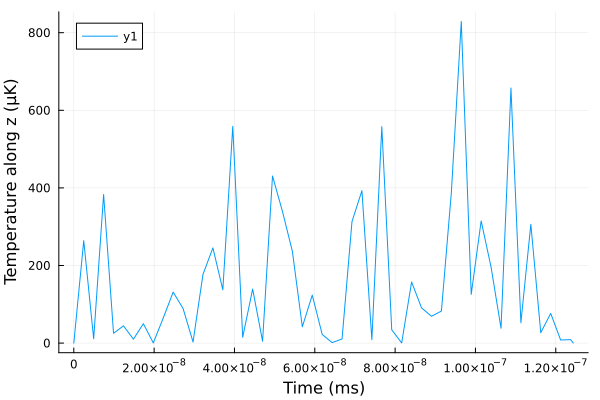

In [1338]:
function temperature_1D(velocity)
    return m * velocity^2 / kB
end

print("Temperature in μK: ", temperature_1D(sqrt(mean(survived_z_velocities[13][1:floor(Int64,end/2)].^2))) * 1e6)
plot(times[1] .* (1e3/Γ), temperature_1D.(survived_x_velocities[5]) .* 1e6,
    xlabel="Time (ms)",
    ylabel="Temperature along z (μK)"
)

In [552]:
goodness(t_end, times, x_trajectories, y_trajectories, z_trajectories, photons_scattered)

LoadError: UndefVarError: `goodness` not defined

In [553]:
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(trajectories)
        if abs(times[i][end] - t_end) <= 1e-3
            push!(_survived, i)
        end
    end
    return _survived
end

function goodness(t_end, times, x_trajectories, y_trajectories, z_trajectories, photons_scattered)
    
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    @printf("Survival: %i / %i", length(_survived), n_molecules)
    println()
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        r = distance(x_trajectories[survived_idx], y_trajectories[survived_idx], z_trajectories[survived_idx], idx_end)
        # if r > 1.0
        #     n += 0.0
        # elseif r > 0.5
        #     n += 0.1 * exp(-photons_scattered[survived_idx]/14000)
        # elseif r > 0.3
        #     n += (0.6 - r) * exp(-photons_scattered[survived_idx]/14000)
        # elseif r <= 0.3
        #     n += ((0.3 - r) * 3 + 0.3) * exp(-photons_scattered[survived_idx]/14000)
        # end
        if r <= 50e-3
            r = 50e-3
        end
        n += (1/r^3) * exp(-photons_scattered[survived_idx]/14000)
    end
    return n/n_molecules
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end
;

In [554]:
using Serialization, BayesianOptimization, GaussianProcesses

In [555]:
function f(x)
    
    @printf("s1 = %.2f; s2 = %.2f; s3 = %.2f; Δ1 = %.2fΓ; Δ2 = %.2fΓ, Δ3 = %.2fΓ; B_gradient = %.2f; ramp_time = %.2e", x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8] * 1e-3)
    println()
    
    s1 = x[1]
    s2 = x[2]
    s3 = x[3]

    Δ1 = x[4]
    Δ2 = x[5]
    Δ3 = x[6]

    B_gradient = x[7]
    B_ramp_time = x[8] * 1e-3 
    
    prob.p.sim_params.s1 = s1
    prob.p.sim_params.s2 = s2
    prob.p.sim_params.s3 = s3
    prob.p.sim_params.Δ1 = Δ1
    prob.p.sim_params.Δ2 = Δ2
    prob.p.sim_params.Δ3 = Δ3
    prob.p.sim_params.B_gradient = B_gradient
    prob.p.sim_params.B_ramp_time = B_ramp_time
    
    ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
    
    n_molecules = 20
    @time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleDistributed(); trajectories=n_molecules)
    
    # Analyze all the solutions
    x_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
    y_trajectories = Array{Vector{Float64}}(fill([],n_molecules)) 
    z_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
    x_velocities = Array{Vector{Float64}}(fill([],n_molecules))
    y_velocities = Array{Vector{Float64}}(fill([],n_molecules))
    z_velocities = Array{Vector{Float64}}(fill([],n_molecules))
    photons_scattered = zeros(n_molecules)

    times = Array{Vector{Float64}}(fill([],n_molecules))

    for i ∈ 1:n_molecules
        sol_u = ensemble_sol[i].u
        sol_t = ensemble_sol[i].t

        x_trajectories[i] = [x_trajectories[i]; [real(u[n_states + n_excited + 1]) for u in sol_u] ./ k*1e3]
        y_trajectories[i] = [y_trajectories[i]; [real(u[n_states + n_excited + 2]) for u in sol_u] ./ k*1e3]
        z_trajectories[i] = [z_trajectories[i]; [real(u[n_states + n_excited + 3]) for u in sol_u] ./ k*1e3]

        x_velocities[i] = [x_velocities[i]; [real(u[n_states + n_excited + 4]) for u in sol_u] ./ (k/Γ)]
        y_velocities[i] = [y_velocities[i]; [real(u[n_states + n_excited + 5]) for u in sol_u] ./ (k/Γ)]
        z_velocities[i] = [z_velocities[i]; [real(u[n_states + n_excited + 6]) for u in sol_u] ./ (k/Γ)]
        
        photons_scattered[i] = ensemble_sol[i].prob.p.n_scatters

        times[i] = sol_t .* (1/Γ)
    end
    
    _goodness = goodness(t_end, times, x_trajectories, y_trajectories, z_trajectories, photons_scattered) * 100

    @printf("goodness = %.3f", _goodness)
    println()
    
    return _goodness
end
;

In [556]:
opt = deserialize("opt_3bluefreq_smallerrange.jl")
;

LoadError: SystemError: opening file "opt_3bluefreq_smallerrange.jl": No such file or directory

In [557]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]
plot(moving_average(opt.model.y, 100)) 

LoadError: UndefVarError: `opt` not defined

In [558]:
opt.observed_optimum |> display
opt.observed_optimizer |> display

LoadError: UndefVarError: `opt` not defined

In [559]:
opt.model_optimum |> display
opt.model_optimizer |> display

LoadError: UndefVarError: `opt` not defined

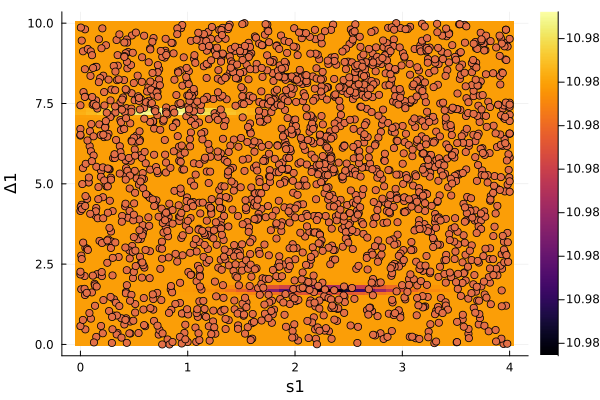

In [90]:
# variables = ["s1", "s2", "s3", "s4", "Δ1=Δ3", "Δ2", "Δ4"]
variables = ["s1", "s2", "s3", "Δ1", "Δ2", "Δ3", "grad", "ramp_time"]

idx1 = 1
idx2 = 4

list1 = opt.lowerbounds[idx1]:0.1:opt.upperbounds[idx1]
list2 = opt.lowerbounds[idx2]:0.1:opt.upperbounds[idx2]

preds_mat = zeros(length(list1), length(list2))
points = zeros(8, 1)

for (i, val1) ∈ enumerate(list1)
    for (j, val2) ∈ enumerate(list2)
        points[:,1] .= opt.model_optimizer
        points[idx1,1] = val1
        points[idx2,1] = val2
        preds_mat[i,j] = predict_y(opt.model, points)[1][1]
    end
end
heatmap(list1, list2, preds_mat')
scatter!(opt.model.x[idx1,:], opt.model.x[idx2,:], legend=nothing, xlabel=variables[idx1], ylabel=variables[idx2])